# Intro to Pyro models

This is Part I of the time series tutorial https://pyro.ai/time
See also [Part II](https://pyro.ai/time/part_ii_inference.ipynb) and
[Part III](https://pyro.ai/time/part_iii_custom.ipynb).

## Setup

First install Pyro
```sh
pip install pyro-ppl
```
and import Pyro and PyTorch

In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
pyro.enable_validation()
print(pyro.__version__)
print(torch.__version__)

0.4.1
1.2.0


### The Pyro language has two basic primitives
```py
x = pyro.sample(“x”, Bernoulli(0.5))
assert isinstance(x, torch.Tensor)

pyro.sample(“data”, Normal(0., 1.),
            obs=data)

theta = pyro.param(“theta”, torch.ones(100),
                   constraint=positive)
```

The first `sample()` generates a random value and records it in the Pyro runtime.

The second `sample()` conditions on observed data.

The final `param()` statement declares a learnable parameter.

### Pyro models are Python functions

构建模型，得到观测数据。

Here is a Pyro model for Poisson regression

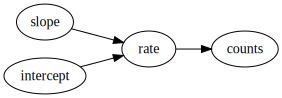

In [2]:
from graphviz import Source
Source('Digraph {rankdir=LR; slope, intercept -> rate -> counts}')

In [3]:
def model(counts):
    slope = pyro.sample("slope", dist.Normal(0, 0.1))
    intercept = pyro.sample("intercept", dist.Normal(math.log(10), 1))
    for t in range(len(counts)):
        rate = torch.exp(intercept + slope * t)
        counts[t] = pyro.sample("count_{}".format(t), dist.Poisson(rate),
                                obs=counts[t])
    return slope, intercept, counts

model([None] * 4)

(tensor(-0.0482),
 tensor(1.9773),
 [tensor(5.), tensor(10.), tensor(11.), tensor(5.)])

Note this has two sample statements and an observe statement. There are no learnable parameters.

## 模型可以生成数据

Pyro models can generate data

Running a Pyro model will generate a sample from the prior.

true_counts = tensor([ 9., 10., 10., 12., 16., 13., 20., 16., 34., 29.])


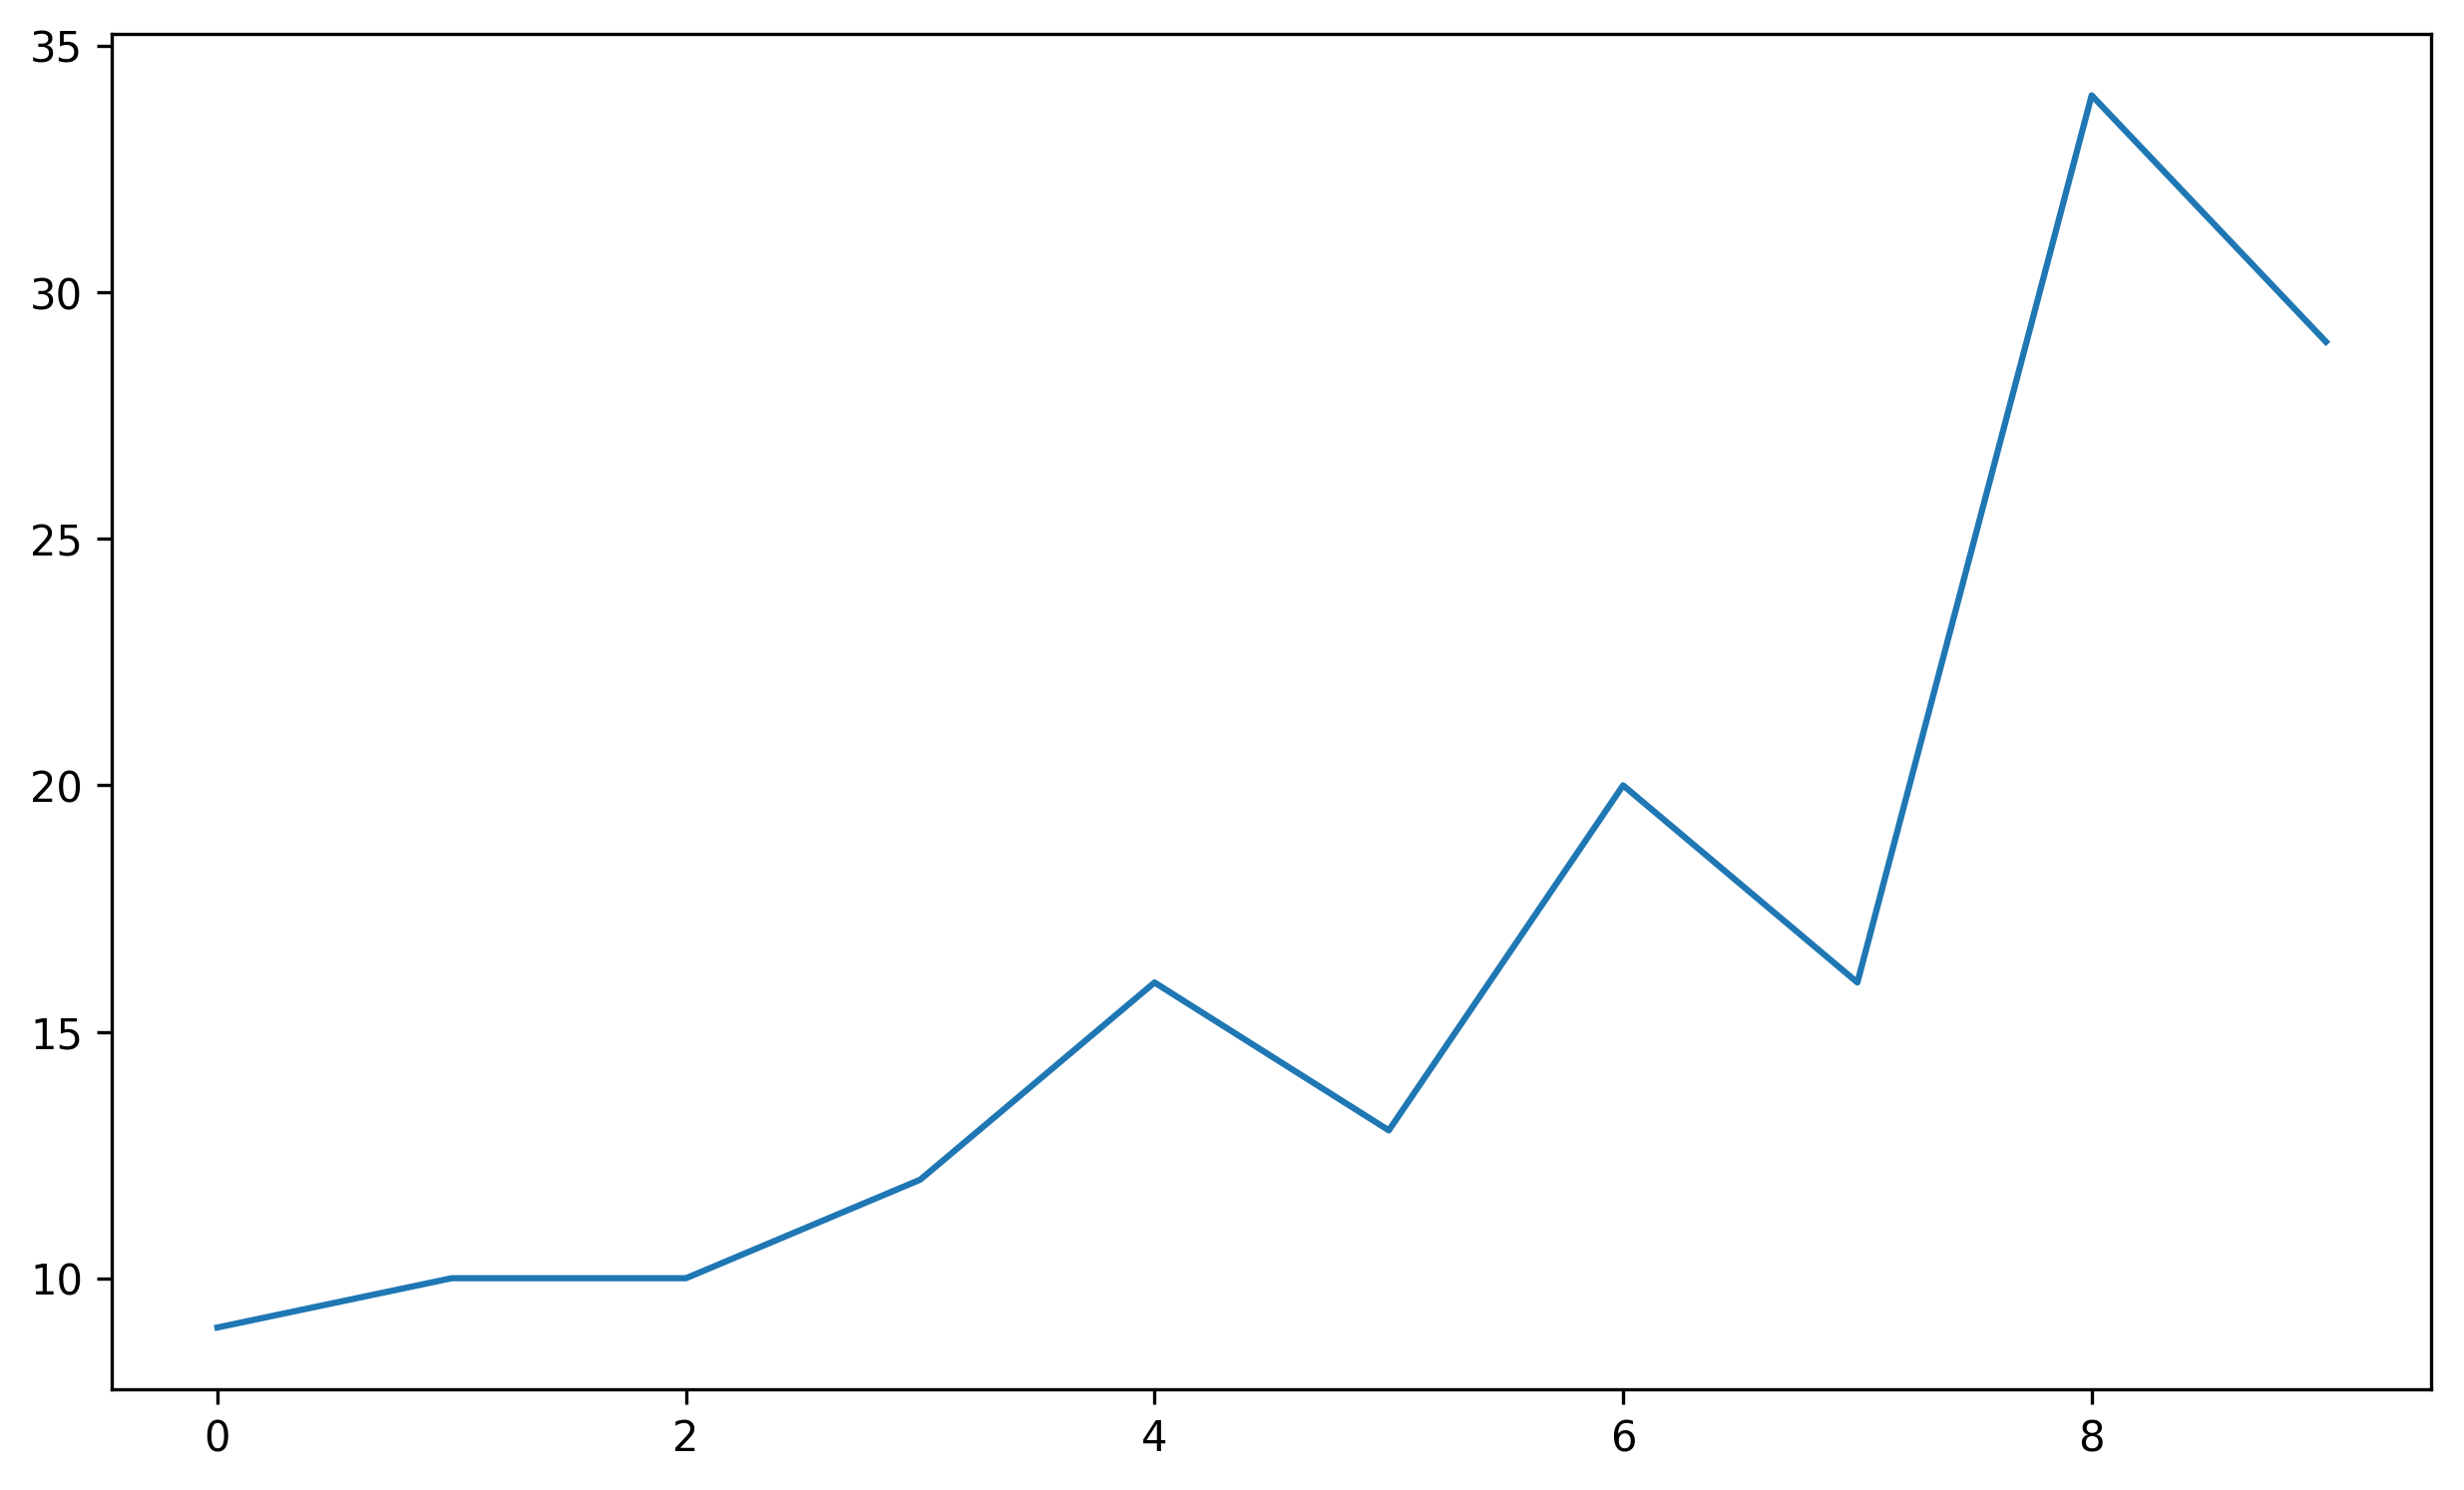

In [4]:
pyro.set_rng_seed(0)

# We pass counts = [None, ..., None] to indicate time duration.
true_slope, true_intercept, true_counts = model([None] * 10)
print("true_counts = {}".format(torch.stack(true_counts)))

pyplot.figure(figsize=(10, 6), dpi=300)
pyplot.plot([c.item() for c in true_counts]);

## 参数后验分布

**We can guess parameters of the model from data**

We just saw one way to use a Pyro model -- to call it via `model()`.

Another way to use a model is to pass the model to an inference algorithm and let the algorithm guess what the model is doing based on observed data (here `true_counts`). This way of using a model is a _nonstandard interpretation_ of the model.

In [5]:
%%time
# This uses Pyro inference algorithms which we'll discuss later in Part II.
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

guide = AutoDelta(model)
svi = SVI(model, guide, Adam({"lr": 0.1}), Trace_ELBO())
for i in range(101):
    loss = svi.step(true_counts)  # true_counts is passed as argument to model()
    if i % 10 == 0:
        print("loss = {}".format(loss))

loss = 35.54213219881058
loss = 27.14454448223114
loss = 26.344421565532684
loss = 26.64658695459366
loss = 26.37659978866577
loss = 26.328715980052948
loss = 26.29265558719635
loss = 26.294653832912445
loss = 26.29331511259079
loss = 26.29179358482361
loss = 26.291207492351532
CPU times: user 538 ms, sys: 12.8 ms, total: 550 ms
Wall time: 550 ms


In [10]:
print("true_slope = {}".format(true_slope))
print("true_intercept = {}".format(true_intercept))
guess = guide()
print("guess = {}".format(guess))

true_slope = 0.15409961342811584
true_intercept = 2.0091562271118164
guess = {'slope': tensor(0.1365, grad_fn=<ExpandBackward>), 'intercept': tensor(2.1379, grad_fn=<ExpandBackward>)}


## The `guide` is also a Pyro model

Note that the `guide` is also a Pyro model (created by `AutoDelta`). The guide has `pyro.param` statements that declare tunable parameters. We'll write custom guides later in [Part III](https://pyro.ai/time/part_iii_custom.ipynb).

## We then predict future data

有了 guide 之后，我们可以进行预测。

We've now seen two ways to use a model: 
- to generate data from the prior, and
- to learn parameters from data.

A third way to use a Pyro model is to **predict new observed data by guiding the model**(背后的数学是什么样子？). This uses two of Pyro's effects:

- `trace` records guesses made by the guide, and
- `replay` conditions the model on those guesses, allowing the model to generate conditional samples.

We'll wrap this idiom as a `forecast()` method:

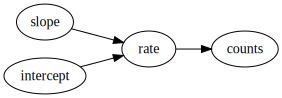

In [7]:
from graphviz import Source
Source('Digraph {rankdir=LR; slope, intercept -> rate -> counts}')

In [8]:
from pyro import poutine

def forecast(forecast_steps=10):
    counts = true_counts + [None] * forecast_steps  # observed data + blanks to fill in
    guide_trace = poutine.trace(guide).get_trace(counts)
    _, _, counts = poutine.replay(model, guide_trace)(counts)
    return counts

out = forecast(3)
print('observed trace', [x.item() for x in true_counts])
print('trace', [x.item() for x in out])

observed trace [9.0, 10.0, 10.0, 12.0, 16.0, 13.0, 20.0, 16.0, 34.0, 29.0]
trace [9.0, 10.0, 10.0, 12.0, 16.0, 13.0, 20.0, 16.0, 34.0, 29.0, 39.0, 44.0, 48.0]


## Pyro predicts by drawing samples

We can now call `forecast()` multiple times to generate samples.

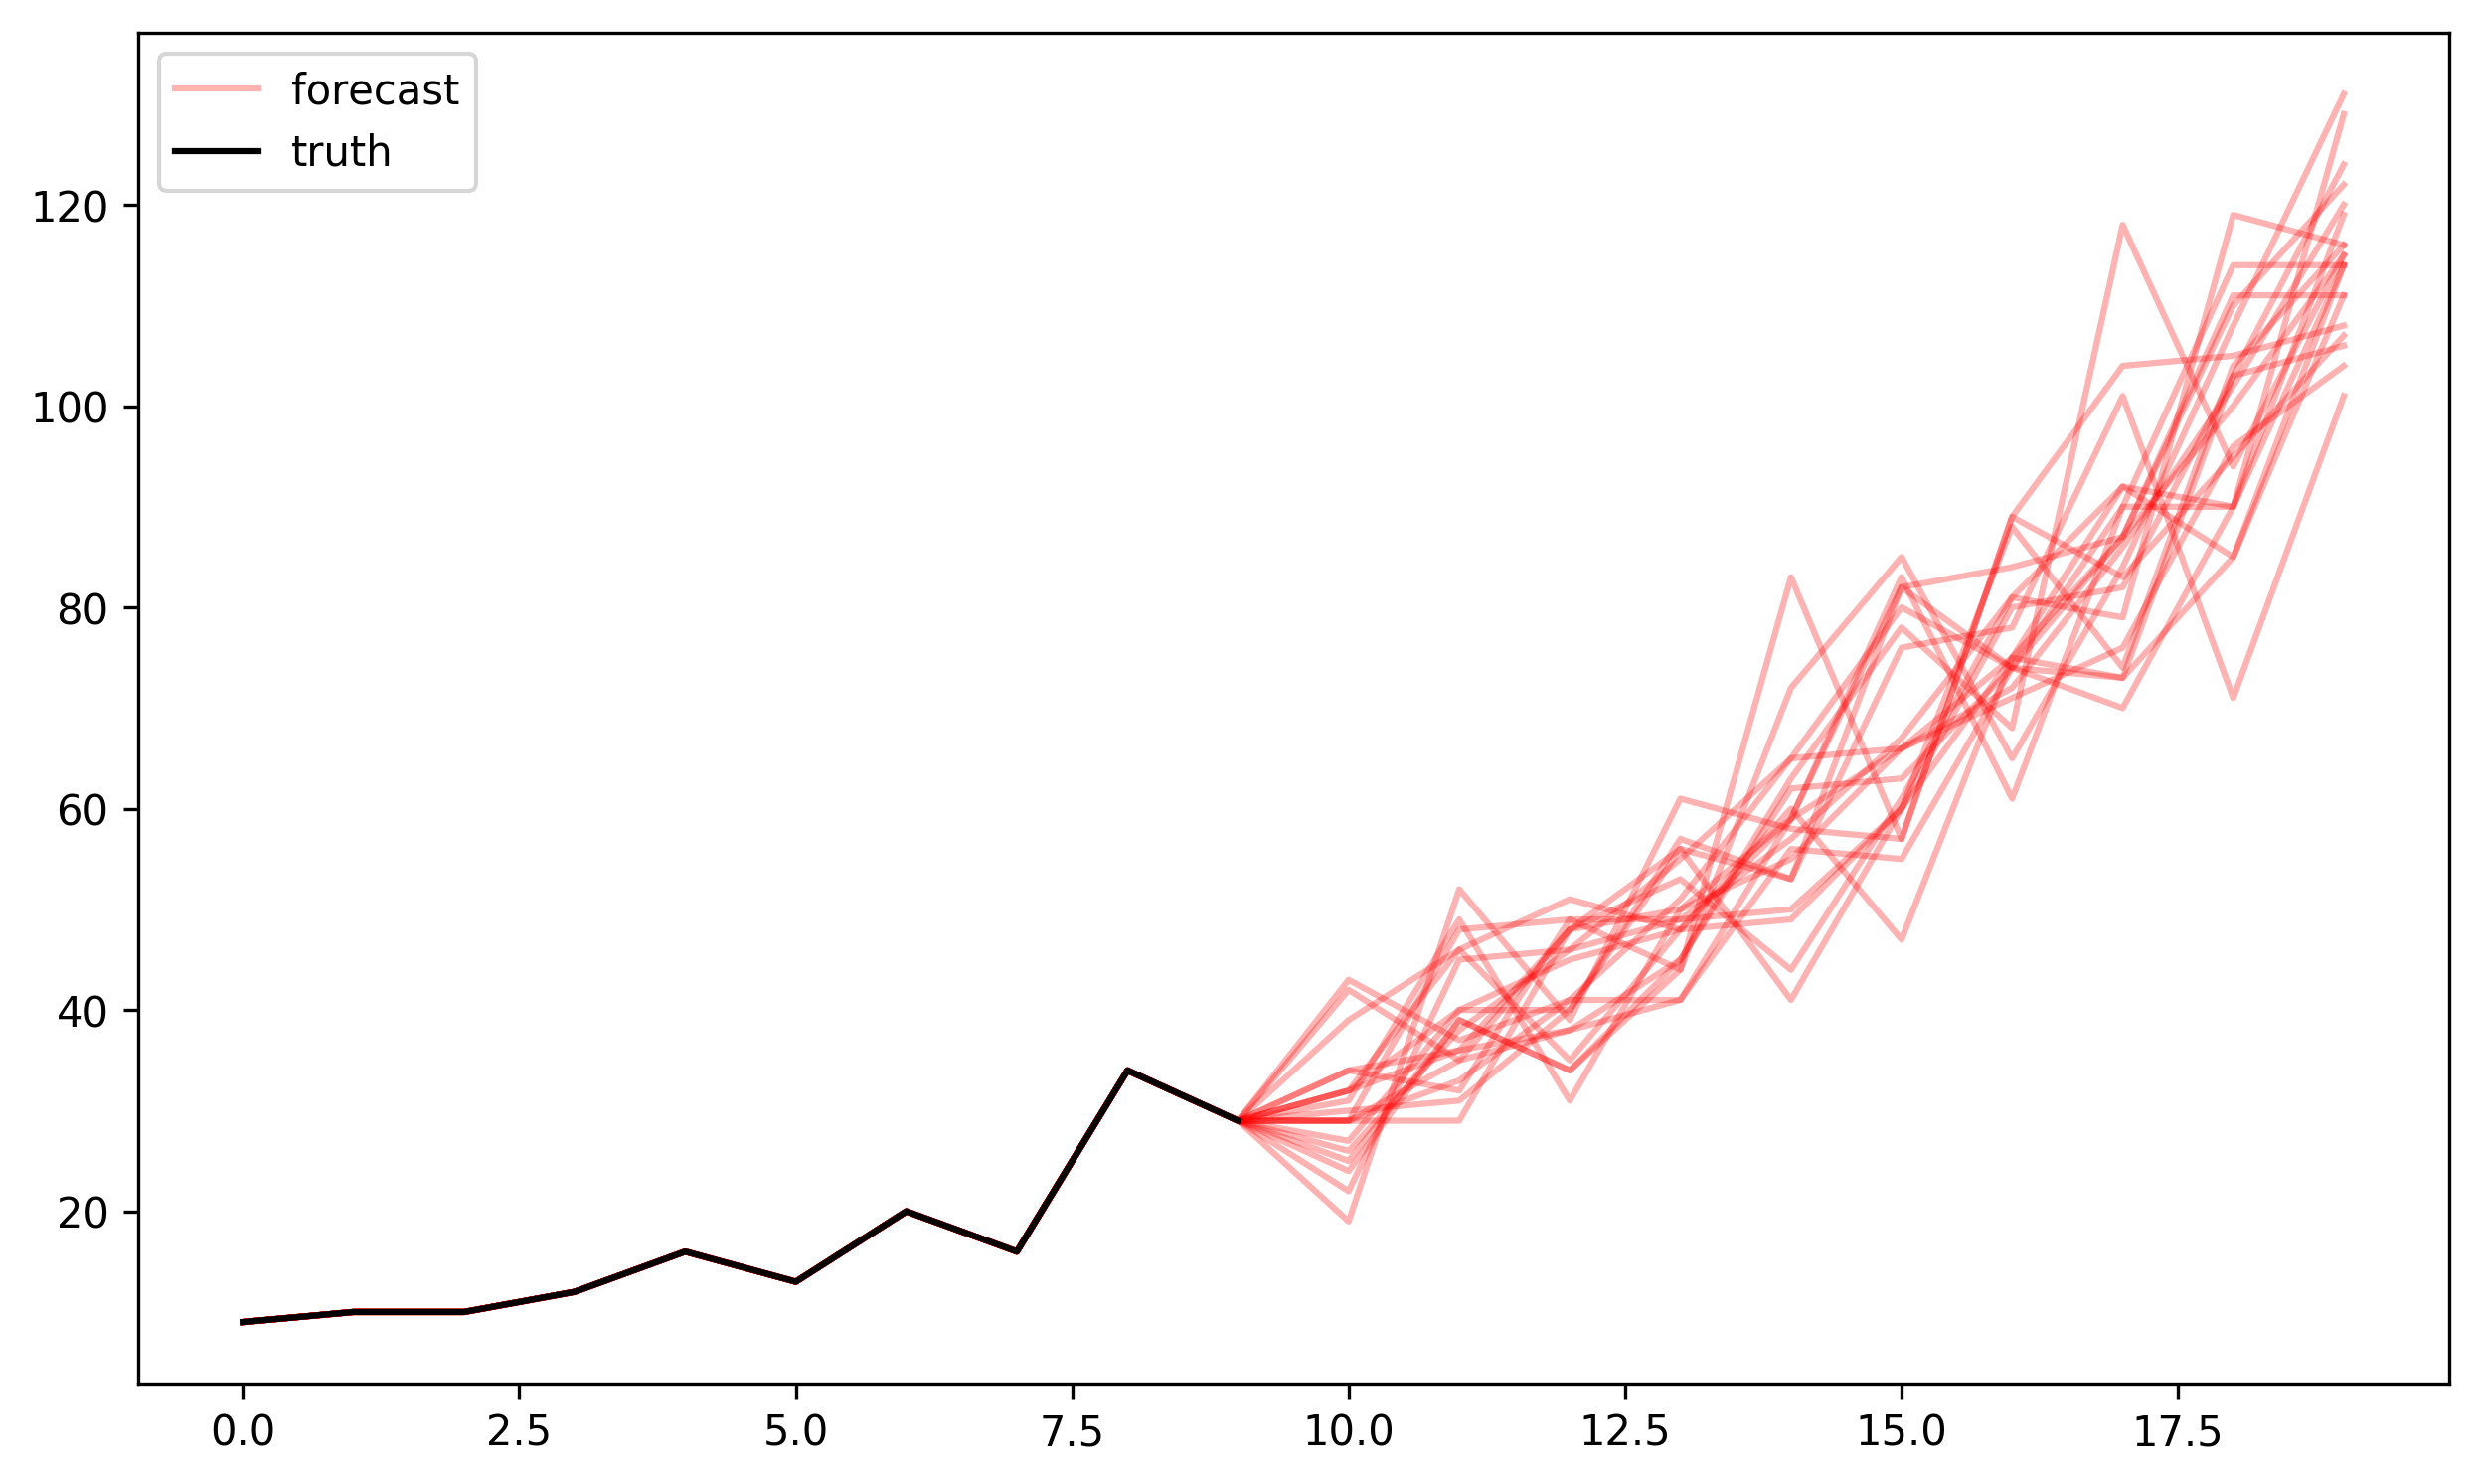

In [15]:
num_samples = 20
pyplot.figure(figsize=(10, 6), dpi=300)
for _ in range(num_samples):
    full_counts = forecast(10)
    \
    forecast_counts = full_counts[len(true_counts):]
    pyplot.plot([c.item() for c in full_counts], "r",
                label=None if _ else "forecast", alpha=0.3)
pyplot.plot([c.item() for c in true_counts], "k-", label="truth")
pyplot.legend();

## Summary

We've seen three ways to interpret Pyro models:
1. Running the models to generate data from the prior.
   This is the _standard interpretation_.
2. Training a guide to guess hidden variables in the model from data.
3. Replaying the model using the trained guide.

## Next steps

In [Part II](https://pyro.ai/time/part_ii_inferenc.ipynb) we'll explore other inference methods in Pyro.